# AntiFungalML

## Description
This is a script for the data analysis and training machine learning models

#### Data Analysis:
    1. Lipinski property calculation and comparison between positive and negative dataset
    2. Perform PCA analysis to show if PCA can explain the differences between positive and negative sets
    3. Perform tSNE and uMAP analysis to explain the differences between positive and negative sets
    4. Difference between the chemical classes in positive and negative sets

#### ML models
    a. Random Forest
    b. Gradient Boosting Tree
    c. Support vector machine
    d. Deep Neural Network
<br></br>

### Data Analysis

#### Step 1: Lipinski Property Calculations

In [19]:
# Lipinski Properties Calculation of Postive dataset

import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit import RDLogger

# Only show critical warnings
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

# Define a function for Lipinski Property Calculation
def LipinskiPropertyCalculation(sdfFile):
    
    # Load the sdfFile
    suppl = Chem.SDMolSupplier(sdfFile)
    
    # Check if any molecule is empty
    mols = [mol for mol in suppl if mol is not None]
    
    # Extract desired properties into a list of dictionaries
    data = list()
    names = list()
    
    
    for mol in mols:
        if mol is not None:
            name = mol.GetProp("Name")
            names.append(name)
     
        # Append all the properties in the data list 
        data.append({
            'SMILES': Chem.MolToSmiles(mol),
            'Name':  name,
            'MolecularWeight': Descriptors.MolWt(mol),
            'LogP': Descriptors.MolLogP(mol),
            'HBD': Descriptors.NumHDonors(mol),
            'HBA': Descriptors.NumHAcceptors(mol)
        })
    return data


if __name__=='__main__':

    # Give the name of the sdf file
    sdfFile = '/work/gsriva2/MLProject_MP_KM_AM/Antifungal-Positive.sdf'
    
    # Run the calculations
    data = LipinskiPropertyCalculation(sdfFile)
    
    # Create a pandas DataFrame from the data
    data = pd.DataFrame.from_dict(data)

    # Save the data into a TSV file
    data.to_csv('/work/gsriva2/MLProject_MP_KM_AM/Antifungal_Positive_LipinskiProperties.tsv', sep='\t', index=False)


In [18]:
from rdkit import Chem
from rdkit.Chem import Descriptors
import pandas as pd
from rdkit import RDLogger

# Only show critical warnings
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

def SMILES2CanonicalSMILES(infile):
	
	# Load the SMILES data
	data = pd.read_csv(infile)

	# Iterate over each row
	for id, row in data.iterrows():
		smiles = row['SMILES']
		# Read smiles and check if they are valid canonical smiles or not
		try:
			CanonicalSmiles = Chem.CanonSmiles(smiles)
			data.loc[id, "CanonicalSMILES"] = CanonicalSmiles
		except:
			data.loc[id, "CanonicalSMILES"] = "Not a valid SMILES"
	return data

def CalculateLipinskiRule(data):
	
	# Initialize lists to store Lipinski properties
	mw, logp, hbd, hba = [], [], [], []
	# Iterate over each row
	for _, row in data.iterrows():
		smiles = row.SMILES
		# Read smiles and check if they are valid canonical smiles or not
		try:
			mol = Chem.MolFromSmiles(smiles)
			if mol:
				# Calculate Lipinski properties
				mw.append(Descriptors.MolWt(mol))
				logp.append(Descriptors.MolLogP(mol))
				hbd.append(Descriptors.NumHDonors(mol))
				hba.append(Descriptors.NumHAcceptors(mol))
			else:
				mw.append(None)
				logp.append(None)
				hbd.append(None)
				hba.append(None)
		except:
			mw.append(None)
			logp.append(None)
			hbd.append(None)
			hba.append(None)
	
	# Add Lipinski properties to the DataFrame
	# 1. Molecular Weight
	data['MolecularWeight'] = mw
	# 2. Water Octanol partition coefficient
	data['LogP'] = logp
	# 3. Hydrogen Bond Donors
	data['HBD'] = hbd
	# 4. Hydrogen Bond Acceptor
	data['HBA'] = hba
	
	return data


if __name__=="__main__":
    
    inputFilePath = '/work/gsriva2/MLProject_MP_KM_AM'
    
    data = SMILES2CanonicalSMILES(f'{inputFilePath}/Antifungal-Negative.csv')
    
    data = CalculateLipinskiRule(data)
    
    data.to_csv(f'{inputFilePath}/Antifungal_Negative_LipinskiProperties.tsv', sep="\t", index=False)
	


[00:24:46] Explicit valence for atom # 21 N, 4, is greater than permitted
[00:24:47] Explicit valence for atom # 1 Cl, 4, is greater than permitted
[00:24:51] Explicit valence for atom # 21 N, 4, is greater than permitted
[00:24:52] Explicit valence for atom # 1 Cl, 4, is greater than permitted


#### Step 3: Plot Lipinski Properties comparing the two groups (positive and negative) with p value 

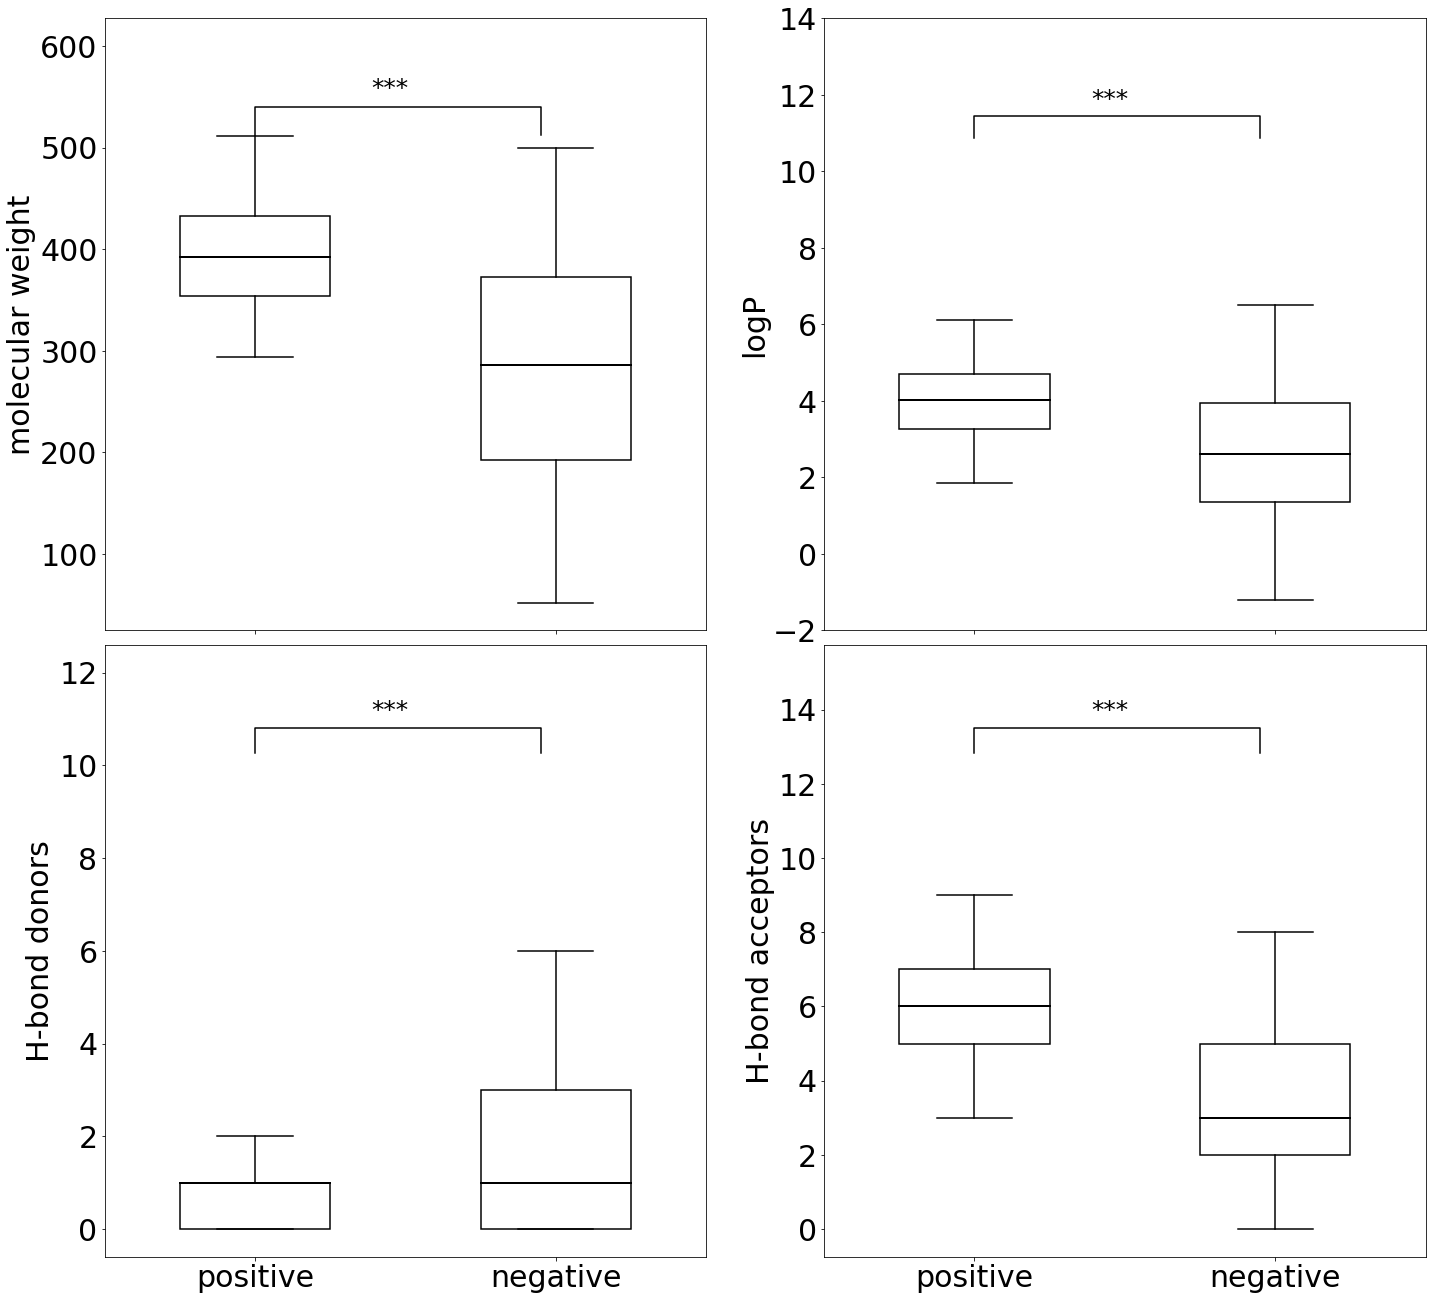

In [101]:
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load the positive dataset
positive_data = pd.read_csv('/work/gsriva2/MLProject_MP_KM_AM/Antifungal_Positive_LipinskiProperties.tsv', sep='\t')
positive_data['Category'] = 'positive'

# Load the negative dataset
negative_data = pd.read_csv('/work/gsriva2/MLProject_MP_KM_AM/Antifungal_Negative_LipinskiProperties.tsv', sep='\t')
negative_data['Category'] = 'negative'
negative_data = negative_data.rename(columns={'NAME': 'Name'})
negative_data = negative_data[['SMILES', 'Name', 'MolecularWeight', 'LogP', 'HBD', 'HBA', 'Category']]

# Combine datasets
combined_data = pd.concat([positive_data, negative_data])

# Convert numeric columns to float
numeric_columns = ["MolecularWeight", "LogP", "HBD", "HBA"]
combined_data[numeric_columns] = combined_data[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Drop NaN values from numeric columns
combined_data = combined_data.dropna(subset=numeric_columns)

# Create a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(20, 18), sharex=True)
fig.subplots_adjust(wspace=0.3)

# Define properties and corresponding axes
properties = ["MolecularWeight", "LogP", "HBD", "HBA"]
titles = ["molecular weight", "logP", "H-bond donors", "H-bond acceptors"]

# Significance thresholds
thresholds = {0.001: "***", 0.01: "**", 0.05: "*", 0.1: "•"}

# Perform t-tests and plot
for i, (prop, title) in enumerate(zip(properties, titles)):
    row, col = divmod(i, 2)  # Determine subplot position

    # Extract values
    pos_values = combined_data[combined_data["Category"] == "positive"][prop].dropna()
    neg_values = combined_data[combined_data["Category"] == "negative"][prop].dropna()

    # Check for zero variance
    significance_label = ""
    if pos_values.var() == 0 or neg_values.var() == 0:
        p_value = np.nan  # If variance is zero, t-test is invalid
    else:
        t_stat, p_value = ttest_ind(pos_values, neg_values, equal_var=False)

        # Assign significance label
        for threshold, label in thresholds.items():
            if p_value < threshold:
                significance_label = label
                break

    # Plot boxplot with customized style
    sns.boxplot(
        x="Category", y=prop, data=combined_data, ax=axes[row, col], width=0.5, fliersize=0,
        boxprops={'facecolor': 'none', 'edgecolor': 'black'},
        whis=1,
        whiskerprops={'color': 'black', 'linestyle': '-', 'linewidth': 1.5},
        capprops={'color': 'black', 'linewidth': 1.5},
        medianprops={'color': 'black', 'linewidth': 2}
    )
    
    axes[row, col].set_xlabel("")
    axes[row, col].set_ylabel(title, fontsize=30)
    axes[row,col].tick_params(axis='both', which='major', labelsize=30)

    # Draw significance arrow only if valid p-value
    if significance_label:
        y_max = max(pos_values.max(), neg_values.max()) * 0.9  # Get max y value for annotation
        axes[row, col].plot([0, 0, 0.95, 0.95], [y_max * 0.95, y_max, y_max, y_max * 0.95], lw=1.5, color='black')
        axes[row, col].text(0.45, y_max * 1.02, significance_label, ha='center', fontsize=25, color='black')

#axes[0,0].set_ylim(100,600)
axes[0,1].set_ylim(-2, 14)
#axes[1,0].set_ylim(-1,8)

# Adjust layout
plt.tight_layout()

# Save figure
plt.savefig('lipinskiproperties.png', 
        dpi=600, 
        format='png', 
        pil_kwargs={"compression": "png_lzw"}
    )
